## Preface

This is an analysis of Wikipedia comments to create models that identify various types of toxic comments. There is a lot of racist content and swear words in the dataset and some of it will pop up in the analysis. 

In [1]:
import pandas as pd
import numpy as np
import nltk
import keras
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
start = time.time()
def print_time(start):
    time_now = time.time() - start 
    minutes = int(time_now / 60)
    seconds = int(time_now % 60)
    if seconds < 10:
        print('Elapsed time was %d:0%d.' % (minutes, seconds))
    else:
        print('Elapsed time was %d:%d.' % (minutes, seconds))

# Load Data

In [3]:
df = pd.read_csv('train.csv')
df_sub = pd.read_csv('test.csv')

submission = pd.DataFrame()
submission['id'] = df_sub.id.copy()

In [4]:
def null_percentage(column):
    df_name = column.name
    nans = np.count_nonzero(column.isnull().values)
    total = column.size
    frac = nans / total
    perc = int(frac * 100)
    print('%d%% or %d missing from %s column.' % 
          (perc, nans, df_name))

def check_null(df, columns):
    for col in columns:
        null_percentage(df[col])
        
check_null(df, df.columns)

0% or 0 missing from id column.
0% or 0 missing from comment_text column.
0% or 0 missing from toxic column.
0% or 0 missing from severe_toxic column.
0% or 0 missing from obscene column.
0% or 0 missing from threat column.
0% or 0 missing from insult column.
0% or 0 missing from identity_hate column.


# EDA 

In [5]:
print('%d features and %d records.' % (df.shape[1], df.shape[0]))
print()
targets = list(df.columns[2:])
print('Target columns: ' + ', '.join(targets))

8 features and 159571 records.

Target columns: toxic, severe_toxic, obscene, threat, insult, identity_hate


In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


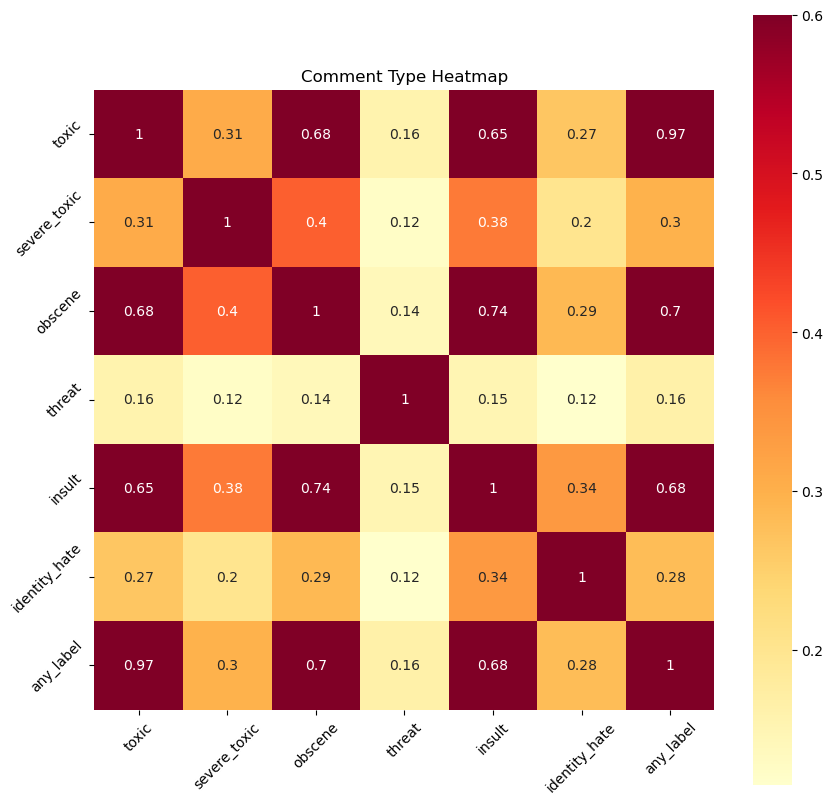

Training Data Comment Breakdown
=====

16225 out of 159571 comments, or 10.17%, are classified as toxic.

15294 toxic comments. (9.58% of all data.)
- 1595 or 10.43% were also severe_toxic.
- 7926 or 51.82% were also obscene.
- 449 or 2.94% were also threat.
- 7344 or 48.02% were also insult.
- 1302 or 8.51% were also identity_hate.
- 15294 or 100.00% were also any_label.

1595 severe_toxic comments. (1.00% of all data.)
- 1595 or 100.00% were also toxic.
- 1517 or 95.11% were also obscene.
- 112 or 7.02% were also threat.
- 1371 or 85.96% were also insult.
- 313 or 19.62% were also identity_hate.
- 1595 or 100.00% were also any_label.

8449 obscene comments. (5.29% of all data.)
- 7926 or 93.81% were also toxic.
- 1517 or 17.95% were also severe_toxic.
- 301 or 3.56% were also threat.
- 6155 or 72.85% were also insult.
- 1032 or 12.21% were also identity_hate.
- 8449 or 100.00% were also any_label.

478 threat comments. (0.30% of all data.)
- 449 or 93.93% were also toxic.
- 112 or 23

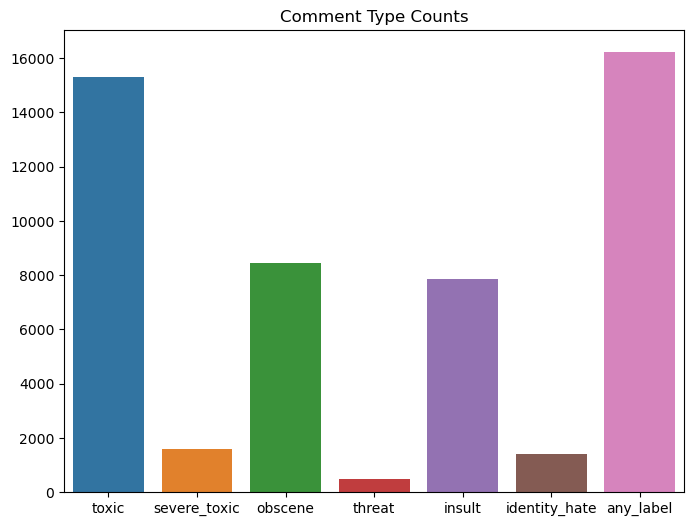

In [7]:
targets = list(df.columns[2:])
df_targets = df[targets].copy()

# How many rows are toxic? 
toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)

# Create overall any_label feature
targets.append('any_label')
df_targets['any_label'] = toxic_rows

count_dic = {}
for comment_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_targets[(df_targets[comment_type]==1)]
    others.remove(comment_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[comment_type] = counts


del(df_selection)

def heatmap(df, title):
    plt.figure('heatmap', figsize=[10,10])
    plt.title(title)
    df_corr = df.corr()
    #df_corr = np.triu(df_corr, k=1)
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd')
    plt.yticks(rotation = 45)
    plt.xticks(rotation = 45)
    plt.show()

heatmap(df_targets, 'Comment Type Heatmap')


print('Training Data Comment Breakdown')
print('=====\n')

print('%d out of %d comments, or %.2f%%, are classified as toxic.' % 
     (np.sum(toxic_rows), len(df), (np.sum(toxic_rows)/len(df))*100))

totals = []
for key, value in count_dic.items():
    totals.append(value[0][1])
    print('\n%d %s comments. (%.2f%% of all data.)' % (value[0][1], key, (value[0][1]/len(df))*100))
    for cnt in value[1:]:
        print('- %d or %.2f%% were also %s.' % (cnt[1], (cnt[1]/value[0][1])*100, cnt[0]))
    

plt.figure('Comment Type Counts', figsize=[8,6])
plt.title('Comment Type Counts')
sns.barplot(x=list(count_dic.keys()), y=totals)
plt.show()

In [8]:
for t in targets:
    print("Label: %s ============================================================" % t)
    b = np.where(df_targets[t]==1)[0]
    selection = np.random.choice(b, 10)
    for s in selection:
        print(df.comment_text.loc[s])
        print("++++++++++++")
    print()
    
b = np.where(df_targets.any_label==0)[0]
selection = np.random.choice(b, 10)
print("Clean comments =========================================")
for s in selection:
    print(df.comment_text.loc[s])
    print("++++++++++++")

Label: toxic ============================================================
"
http://en.wikipedia.org/w/index.php?title=Wikipedia:Sockpuppet_investigations/FaheyUSMC&diff;=prev&oldid;=451979799 
Look Toddst1, you annoying, rude, uncivil bully, I was referring to THE DATING GUY TALK PAGE that I was finally able to read and study the history of after Dragonfly6-7 put it back in viewable status. I can see everything you and your friends did there. I can see the nice neat note from Agent86 where he says he wouldn't go near it any more because of how you people behave. This is not an ""admission of guilt"", this is proof that I went back and read and saw all the shenanigans you were a part of. What is wrong with you that you keep having to hound and harass me? Am I Prisoner 24601 to your Inspector Javert? 76.31.236.91  "
++++++++++++
How are you MudkipsPlz? Or should I call you CHIX0R? Or do you like Angel-of-Losers better?
++++++++++++
"you source Nazi)"" is an example."
++++++++++++
Like I 

Interesting takeaways:
- 'Toxic' represents over 90% of each other category. 
- Though all appear at first glance to be subcategories of toxic, only 'severe_toxic' is 'toxic' 100% of the time. 
- Toxic isn't actually an overall category, some attribute of toxic ends up describing most insults, threats, hate comments, and obscenities. 

We don't have actual definitions of these classifications, so we can't know exactly what they mean and why, for example, all 'identity_hate' comments aren't toxic. If it was higher, like 99%, I'd say labeling error, and just make 'toxic' an overall category that's true when any other category is true. 

In [26]:
df.head()

,comment_text,length,caps,word_length,exclamation,question,comment_sequence
0,Explanation\nWhy the edits made under my usern...,264,0.083333,4.500000,0,1,"[678, 77, 1, 130, 133, 179, 31, 664, 4374, 109..."
1,D'aww! He matches this background colour I'm s...,112,0.108108,6.250000,1,0,"[166, 52, 2587, 13, 548, 3712, 3, 70, 4424, 26..."
2,"Hey man, I'm really not trying to edit war. It...",233,0.021390,4.638889,0,0,"[409, 420, 3, 70, 137, 14, 252, 2, 76, 312, 10..."
3,"""\nMore\nI can't make any real suggestions on ...",622,0.022587,4.212766,0,0,"[60, 3, 37, 22, 99, 57, 327, 1422, 15, 2074, 3..."
4,"You, sir, are my hero. Any chance you remember...",67,0.039216,4.125000,0,1,"[6, 1661, 19, 31, 3377, 57, 1059, 6, 573, 42, ..."


In [9]:
df['length'] = df.comment_text.apply(lambda x: len(x))
print("Average toxic comment length: %d" % int(np.mean(df[(df_targets.any_label==1)].length)))
print("Average clean comment length: %d" % int(np.mean(df[(df_targets.any_label==0)].length)))

Average toxic comment length: 303
Average clean comment length: 404


In [10]:
print("Median toxic comment length: %d" % int(np.median(df[(df_targets.any_label==1)].length)))
print("Median clean comment length: %d" % int(np.median(df[(df_targets.any_label==0)].length)))

Median toxic comment length: 128
Median clean comment length: 216


In [11]:
def pct_caps(s):
    return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))
print("Percent of capitalized characters in toxic comments: %d%%" % int(100 * np.mean(df[(df_targets.any_label==1)].caps)))
print("Percent of capitalized characters in clean comments: %d%%" % int(100 * np.mean(df[(df_targets.any_label==0)].caps)))

Percent of capitalized characters in toxic comments: 14%
Percent of capitalized characters in clean comments: 5%


In [12]:
def word_length(s):
    s = s.split(' ')
    return np.mean([len(w) for w in s if w.isalpha()])
df['word_length'] = df.comment_text.apply(lambda x: word_length(x))

print("Average word length in toxic comments: %.1f" % np.mean(df[(df_targets.any_label==1)].word_length))
print("Average word length in clean comments: %.1f" % np.mean(df[(df_targets.any_label==0)].word_length))

C:\Users\Windows 10\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Average word length in toxic comments: 4.1
Average word length in clean comments: 4.4


In [13]:
df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))
print("Exclamations in toxic comments: %.1f" % np.mean(df[(df_targets.any_label==1)].exclamation))
print("Exclamations in clean comments: %.1f" % np.mean(df[(df_targets.any_label==0)].exclamation))

Exclamations in toxic comments: 3.5
Exclamations in clean comments: 0.3


In [14]:
df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))
print("Question marks in toxic comments: %.1f" % np.mean(df[(df_targets.any_label==1)].question))
print("Question marks in clean comments: %.1f" % np.mean(df[(df_targets.any_label==0)].question))

Question marks in toxic comments: 0.6
Question marks in clean comments: 0.4


In [15]:
import re
ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
def strip_ip(s, ip):
    try:
        found = ip.search(s)
        return s.replace(found.group(), ' ')
    except:
        return s
    
df.comment_text = df.comment_text.apply(lambda x: strip_ip(x, ip))

Label overlap summary.
1 label: 39.2%
2 labels: 21.4%
3 labels: 25.9%
4 labels: 10.8%
5 labels: 2.4%
6 labels: 0.2%


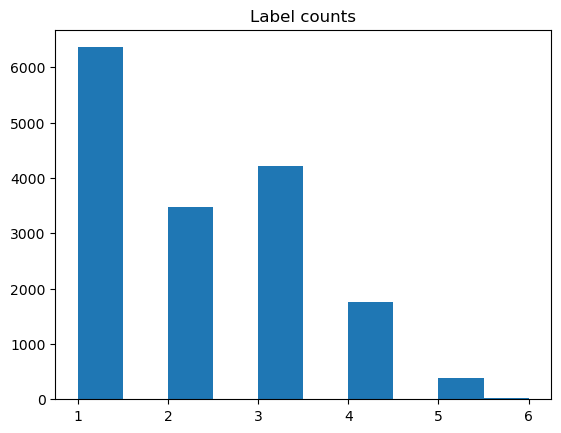

In [16]:
target_sums = np.sum(df_targets[df_targets.columns[:-1]], axis=1)
target_sums = target_sums[(df_targets.any_label==1)]
plt.figure('Label counts')
plt.title('Label counts')
plt.hist(target_sums)
print("Label overlap summary.")
for i in range(1,7):
    print('%d label%s: %.1f%%' % (i, 's' if i > 1 else '', 100 * len([s for s in target_sums if s == i])/len(target_sums)))

### Split Labels from Training Data

In [17]:
print('Training labels:')
print(list(df_targets.columns))
print(df_targets.shape)

print('\nTraining data')
df.drop(list(df_targets.columns[:-1]), inplace=True, axis=1)
df.drop('id', inplace=True, axis=1)
print(list(df.columns))
print(df.shape)

Training labels:
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'any_label']
(159571, 7)

Training data
['comment_text', 'length', 'caps', 'word_length', 'exclamation', 'question']
(159571, 6)


## Natural Language Processing

### Tokenized Sequences for Visualization

In [18]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from nltk.corpus import stopwords
import string

top_words = 5000
tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True, num_words=top_words)
tokenizer.fit_on_texts(df['comment_text'])


In [19]:
df['comment_sequence'] = tokenizer.texts_to_sequences(df.comment_text.str.lower())

In [20]:
# Random comment
str(df.comment_sequence[890])

'[1, 19, 641, 23, 1, 22, 856, 43, 19, 48, 2035, 2, 10, 13, 121, 126, 8, 201, 10, 412, 975, 1126, 17, 10, 10, 13, 8, 1, 1630, 856, 55, 95, 602, 39, 6, 125, 62, 2035, 980, 2379, 14, 969, 4, 3610, 17, 316, 17, 3, 72, 1, 531, 45, 1038, 2221, 641, 23, 62, 1907, 5, 4220, 319, 43, 8, 14, 97, 1, 1353, 4, 32, 842, 36, 42, 1813, 1493, 27, 13, 190, 18, 15, 1, 856, 24, 6, 95, 521, 43, 19, 2379, 39, 1, 2408, 4, 33, 1010, 2523, 2, 11, 2177, 319, 319]'

### Analyze Max Len, Choose Appropriate 'max_len'

In [21]:
max_len = df.comment_sequence.map(lambda x: len(x)).max()
print("Max comment length is %d." % max_len)

Max comment length is 1399.


In [22]:
seq_lens = df.comment_sequence.map(lambda x: len(x))

In [23]:
for i in [10, 50, 100, 200, 300, 400, 500, 1000, 1200]:
    select = (seq_lens > i)
    print('%.2f%% of comments have more than %d words.' % ((np.sum(select)/len(seq_lens))*100, i))

83.34% of comments have more than 10 words.
35.22% of comments have more than 50 words.
16.06% of comments have more than 100 words.
5.61% of comments have more than 200 words.
2.62% of comments have more than 300 words.
1.63% of comments have more than 400 words.
1.08% of comments have more than 500 words.
0.02% of comments have more than 1000 words.
0.01% of comments have more than 1200 words.


So this data is going into an RNN, and less data is always better becase I'm going to be training on a CPU. I'm going to choose a cutoff of 300 words for now. My logic? I feel like an informative long-form comment isn't going to turn into a racist tirade halfway in. The first 300 words should be able to predict the sentiment of the entire comment. I'll experiment more later, this is just a starting point. 

### Visualize Word Counts

In [24]:
def get_word_cnt(tokenizer):
    word_cnt = [(k, v) for k, v in zip(tokenizer.word_counts.keys(), 
                                       tokenizer.word_counts.values())]
    word_cnt.sort(key = lambda tup: tup[1], reverse=True)
    stopWords = set(stopwords.words('english'))
    word_cnt = [tup for tup in word_cnt if tup[0] not in stopWords]
    return word_cnt

def word_plot(word_cnt, num_words, title):
    plt.figure(title, figsize=(24, 12))
    plt.suptitle(title, fontsize=40)
    sns.barplot(x= [tup[0] for tup in word_cnt[0:num_words]], 
                y = [tup[1] for tup in word_cnt[0:num_words]])
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, rotation=35, ha='right')
    plt.show()

In [25]:
all_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
all_tokenizer.fit_on_texts(df.comment_text[(toxic_rows==0)])
word_plot(get_word_cnt(all_tokenizer), 45, 'Clean Comments Only')

for label in targets:
    toxic_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
    toxic_tokenizer.fit_on_texts(df.comment_text[(df_targets[label]==1)])
    word_plot(get_word_cnt(toxic_tokenizer), 45, label + ' Comments Only')
    
toxic_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
toxic_tokenizer.fit_on_texts(df.comment_text[toxic_rows])
word_plot(get_word_cnt(toxic_tokenizer), 45, 'Toxic Comments Only')

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\Windows 10/nltk_data'
    - 'C:\\Users\\Windows 10\\anaconda3\\nltk_data'
    - 'C:\\Users\\Windows 10\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\Windows 10\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Windows 10\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


The vocabulary changes quite dramatically when we look at just the toxic comments. My favorite detail is that people writing toxic comments are more likely to write 'you' as 'u' than 'you.' 

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                      stopwords=set(stopwords.words('english')),
                      max_words=100,
                      max_font_size=40,
                      colormap='Greens'
                         ).generate(str(df.comment_text[(toxic_rows==0)]))
plt.figure('wordcloud', figsize=(24,12))
plt.suptitle('Clean Comments', fontsize=40)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud = WordCloud(background_color='white',
                      stopwords=set(stopwords.words('english')),
                      max_words=100,
                      max_font_size=40,
                      colormap='Reds'
                         ).generate(str(df.comment_text[toxic_rows]))
plt.figure('toxic_wordcloud', figsize=(24,12))
plt.suptitle('Toxic Comments', fontsize=40)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

For some reason I thought Wikipedia would attract a more sophisticated demographic. 